In [1]:
%reload_ext autoreload
%autoreload 2

# Stim class

In [5]:
from soft_info import RepetitionCodeStimCircuit

d = 4
T = 4
resets = False
xbasis = False
logical = '0'
subsampling = False

noise_list = [2e-2, 1e-3, 3e-2, 2e-2, 2e-2/2, 2e-2/2] # [twog_err, sglg_err, idle_err, readout_err, hard_err, soft_err]
noise_list = [0, 0, 0, 0, 0, 1e-1]


code = RepetitionCodeStimCircuit(d, T, xbasis=xbasis, resets=resets, noise_list=noise_list, subsampling=subsampling)

circuit = code.circuits[logical]
# print(circuit)

resets: False, xbasis: False, logical: 0, subsampling: False


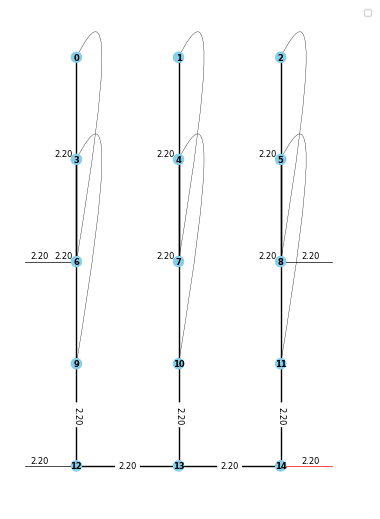

In [7]:
from soft_info import draw_matching_graph
import pymatching

model = circuit.detector_error_model()
matching = pymatching.Matching(model)

print(f"resets: {resets}, xbasis: {xbasis}, logical: {logical}, subsampling: {subsampling}")
draw_matching_graph(matching, d, T, figsize=(5, 5), scale_factor=0.5)

In [7]:
import stim

circ = stim.Circuit()
circ.append('DEPOLARIZE1', 0, arg=0.0)

print(circ)

DEPOLARIZE1(0) 0


# Own stim circ

In [ ]:
import stim
import pymatching
from soft_info import draw_matching_graph

d = 5
T = 0
resets = False

# Readability
rec = stim.target_rec

# Qubit registers
qubits = list(range(2*d-1))
code_qubits = qubits[0::2]
link_qubits = qubits[1::2]

print(f"Qubits: {qubits}")
print(f"Code qubits: {code_qubits}")
print(f"Link qubits: {link_qubits}")



### BLOCKS
# Entangling block
ent_block = stim.Circuit()
LtR_indices = [t for tuple in zip(code_qubits[:-1], link_qubits) for t in tuple]
ent_block.append('CX', LtR_indices)
ent_block.append('TICK')
# R->L CXs
RtL_indices = [t for tuple in zip(code_qubits[1:], link_qubits) for t in tuple]
ent_block.append('CX', RtL_indices)
ent_block.append('TICK')
# Measure 
ent_block.append('MR', link_qubits)

# Detector block
det_block = stim.Circuit()
det_block.append('SHIFT_COORDS', [], (0, 1)) # Shift the coords in time
for idx, l_qubit in enumerate(link_qubits):
    det_block.append('DETECTOR', [rec(-(d-1)+idx), rec(-2*(d-1)+idx)], [1+idx*2, 0])





### START CIRCUIT
# Initialize the circuit
own_circ = stim.Circuit()
own_circ.append('R', qubits)
own_circ.append('TICK')

# First round
own_circ += ent_block
for idx, l_qubit in enumerate(link_qubits):
        own_circ.append('DETECTOR', [rec(-(d-1)+idx)], [1+idx*2, 0])

# Consecutive rounds
own_circ += (ent_block + det_block) * (T-1)

# Final msmt
own_circ.append('MR', code_qubits)
for idx, l_qubit in enumerate(link_qubits):
    rec_list = [-d+idx, -d+idx+1, -d+idx-(d-1)] # [code_1, code_2, link]
    own_circ.append('DETECTOR', [rec(idx) for idx in rec_list], [1+idx*2, 1])

# Logical
own_circ.append('OBSERVABLE_INCLUDE', [rec(-1)], [0])



print("\nStim circuit:\n")
print(own_circ)

own_circ.diagram()
own_circ.diagram('timeline-svg')

# Stim circuit

In [8]:
import stim 

circuit_nf = stim.Circuit.generated("repetition_code:memory", distance=d, rounds=T)
print(circuit_nf)

NameError: name 'd' is not defined

In [16]:
import pymatching
d=3
T=2

avg_noise = {"two_gate": 0.01, "readout": 0.01, "idle": 0.01}

circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=d,
                                rounds=T,
                                after_clifford_depolarization=avg_noise["two_gate"], #two-qubit-fidelity,
                                after_reset_flip_probability=0, #reset error,
                                before_measure_flip_probability=avg_noise["readout"], #measurement error,
                                before_round_data_depolarization=avg_noise["idle"]) #idle error)

model = circuit.detector_error_model(decompose_errors=False)
matching = pymatching.Matching.from_detector_error_model(model)

# draw_matching_graph(matching, d, T, figsize=(2,2), scale_factor=0.5)
print(circuit)

R 0 1 2 3 4
TICK
DEPOLARIZE1(0.01) 0 2 4
CX 0 1 2 3
DEPOLARIZE2(0.01) 0 1 2 3
TICK
CX 2 1 4 3
DEPOLARIZE2(0.01) 2 1 4 3
TICK
X_ERROR(0.01) 1 3
MR 1 3
DETECTOR(1, 0) rec[-2]
DETECTOR(3, 0) rec[-1]
TICK
DEPOLARIZE1(0.01) 0 2 4
CX 0 1 2 3
DEPOLARIZE2(0.01) 0 1 2 3
TICK
CX 2 1 4 3
DEPOLARIZE2(0.01) 2 1 4 3
TICK
X_ERROR(0.01) 1 3
MR 1 3
SHIFT_COORDS(0, 1)
DETECTOR(1, 0) rec[-2] rec[-4]
DETECTOR(3, 0) rec[-1] rec[-3]
X_ERROR(0.01) 0 2 4
M 0 2 4
DETECTOR(1, 1) rec[-2] rec[-3] rec[-5]
DETECTOR(3, 1) rec[-1] rec[-2] rec[-4]
OBSERVABLE_INCLUDE(0) rec[-1]


In [ ]:
print(circuit)

# Get backend noise

In [ ]:
from soft_info import get_avgs_from_dict, get_noise_dict_from_backend, get_repcode_layout
from result_saver import SaverProvider

provider = SaverProvider()
layout = get_repcode_layout(distance=50, backend=provider.get_backend("ibm_sherbrooke"), _is_hex=True)

In [ ]:
avg_noise = get_avgs_from_dict(get_noise_dict_from_backend(provider, device="ibm_sherbrooke", 
                                                           used_qubits=None, date='2023-10-30'), used_qubits=layout)
print(avg_noise)

In [ ]:
avg_noise = get_avgs_from_dict(get_noise_dict_from_backend(provider, device="ibm_sherbrooke", 
                                                           used_qubits=layout, date='2023-10-30'), used_qubits=layout)
print(avg_noise)